In [9]:
import numpy as np
import pandas as pd
import datetime
from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

In [10]:
df_train = pd.read_csv("../input/20181216_train.csv")
df_test = pd.read_csv("../input/20181216_test.csv")

In [11]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [12]:
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/new_merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/prosperity_merchants_latest.csv")
df_train, df_test = merge_new_feature("../input/merchants_numerical_features.csv")
df_train, df_test = merge_new_feature("../input/merchants_item_scale_feature.csv")
df_train, df_test = merge_new_feature("../input/purchase_pattern.csv")
df_train, df_test = merge_new_feature("../input/purchase_pettern_nmf.csv")
df_train, df_test = merge_new_feature("../input/purchase_amount_pettern_nmf.csv")

In [13]:
df_train["Null_count"] = df_train.isnull().sum(axis=1)
df_test["Null_count"] = df_test.isnull().sum(axis=1)

In [14]:
dont_use = ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers', 'category_1_Y_std']

df_train_columns = [c for c in df_train.columns if c not in dont_use]
target = df_train['target']
target_outlier = df_train["outliers"]

In [15]:
max_each_col = np.max(df_train[df_train_columns].values, axis=0)

for i, max_ in enumerate(max_each_col):
    if max_ >= 1e+7:
        df_train[df_train_columns[i]] = 1/(1+np.exp(-1*df_train[df_train_columns[i]].values))
        df_test[df_train_columns[i]] = 1/(1+np.exp(-1*df_test[df_train_columns[i]].values))

In [16]:
drop_col = []
comb = list(combinations(df_train_columns, 2))

for c1, c2 in comb:
    corr = np.corrcoef(df_train[c1], df_train[c2])[0,1]
    if corr >= 0.962:
        print("【{i}】 --- 【{j}】".format(i=c1, j=c2))
        print(corr)
        drop_col.append(c2)
        print("\n"*2)

for col in df_train_columns:
    if col in sorted(set(drop_col)):
        df_train_columns.remove(col)

【hist_authorized_flag_sum】 --- 【hist_card_id_size】
0.9945716227736431



【hist_authorized_flag_sum】 --- 【sales_lag3_div_lag_6_sum】
0.991252479458827



【hist_authorized_flag_sum】 --- 【sales_lag6_div_lag_12_sum】
0.9903479752948366



【hist_authorized_flag_sum】 --- 【puchases_lag3_div_lag_6_sum】
0.9914139390387703



【hist_authorized_flag_sum】 --- 【puchases_lag6_div_lag_12_sum】
0.9903376928990004



【hist_card_id_size】 --- 【sales_lag3_div_lag_6_sum】
0.9975144605006232



【hist_card_id_size】 --- 【sales_lag6_div_lag_12_sum】
0.9968560102554356



【hist_card_id_size】 --- 【puchases_lag3_div_lag_6_sum】
0.9976116876313735



【hist_card_id_size】 --- 【puchases_lag6_div_lag_12_sum】
0.9967725640779598



【hist_purchase_date_diff】 --- 【purchase_term】
0.968714472679401



【new_hist_purchase_date_max】 --- 【new_hist_purchase_date_min】
1.0



【sales_lag3_div_lag_6_sum】 --- 【sales_lag6_div_lag_12_sum】
0.9987015197325084



【sales_lag3_div_lag_6_sum】 --- 【puchases_lag3_div_lag_6_sum】
0.9998921914972795





In [17]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    "max_bin": 256,  # なし
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.73847	valid_1's rmse: 3.77453
[200]	training's rmse: 3.66994	valid_1's rmse: 3.73316
[300]	training's rmse: 3.62224	valid_1's rmse: 3.70993
[400]	training's rmse: 3.58576	valid_1's rmse: 3.6952
[500]	training's rmse: 3.55673	valid_1's rmse: 3.68428
[600]	training's rmse: 3.53198	valid_1's rmse: 3.67609
[700]	training's rmse: 3.51182	valid_1's rmse: 3.67098
[800]	training's rmse: 3.49365	valid_1's rmse: 3.66749
[900]	training's rmse: 3.47781	valid_1's rmse: 3.66429
[1000]	training's rmse: 3.46232	valid_1's rmse: 3.66131
[1100]	training's rmse: 3.44853	valid_1's rmse: 3.65906
[1200]	training's rmse: 3.43535	valid_1's rmse: 3.65699
[1300]	training's rmse: 3.42332	valid_1's rmse: 3.65509
[1400]	training's rmse: 3.41147	valid_1's rmse: 3.65354
[1500]	training's rmse: 3.39992	valid_1's rmse: 3.65195
[1600]	training's rmse: 3.38924	valid_1's rmse: 3.65069
[1700]	training's rmse: 3.37891	valid_1's rm

[700]	training's rmse: 3.50614	valid_1's rmse: 3.68
[800]	training's rmse: 3.48769	valid_1's rmse: 3.67757
[900]	training's rmse: 3.47044	valid_1's rmse: 3.67547
[1000]	training's rmse: 3.45448	valid_1's rmse: 3.6737
[1100]	training's rmse: 3.43959	valid_1's rmse: 3.67262
[1200]	training's rmse: 3.42556	valid_1's rmse: 3.67159
[1300]	training's rmse: 3.41253	valid_1's rmse: 3.67073
[1400]	training's rmse: 3.40033	valid_1's rmse: 3.66995
[1500]	training's rmse: 3.38904	valid_1's rmse: 3.6695
[1600]	training's rmse: 3.37797	valid_1's rmse: 3.66894
[1700]	training's rmse: 3.36734	valid_1's rmse: 3.66836
[1800]	training's rmse: 3.35704	valid_1's rmse: 3.66793
[1900]	training's rmse: 3.34736	valid_1's rmse: 3.66747
[2000]	training's rmse: 3.33733	valid_1's rmse: 3.66717
[2100]	training's rmse: 3.32824	valid_1's rmse: 3.66657
[2200]	training's rmse: 3.31923	valid_1's rmse: 3.66642
[2300]	training's rmse: 3.31068	valid_1's rmse: 3.66599
[2400]	training's rmse: 3.30191	valid_1's rmse: 3.66587


3.6456196720191207

In [18]:
# score:  3.6467757129353053

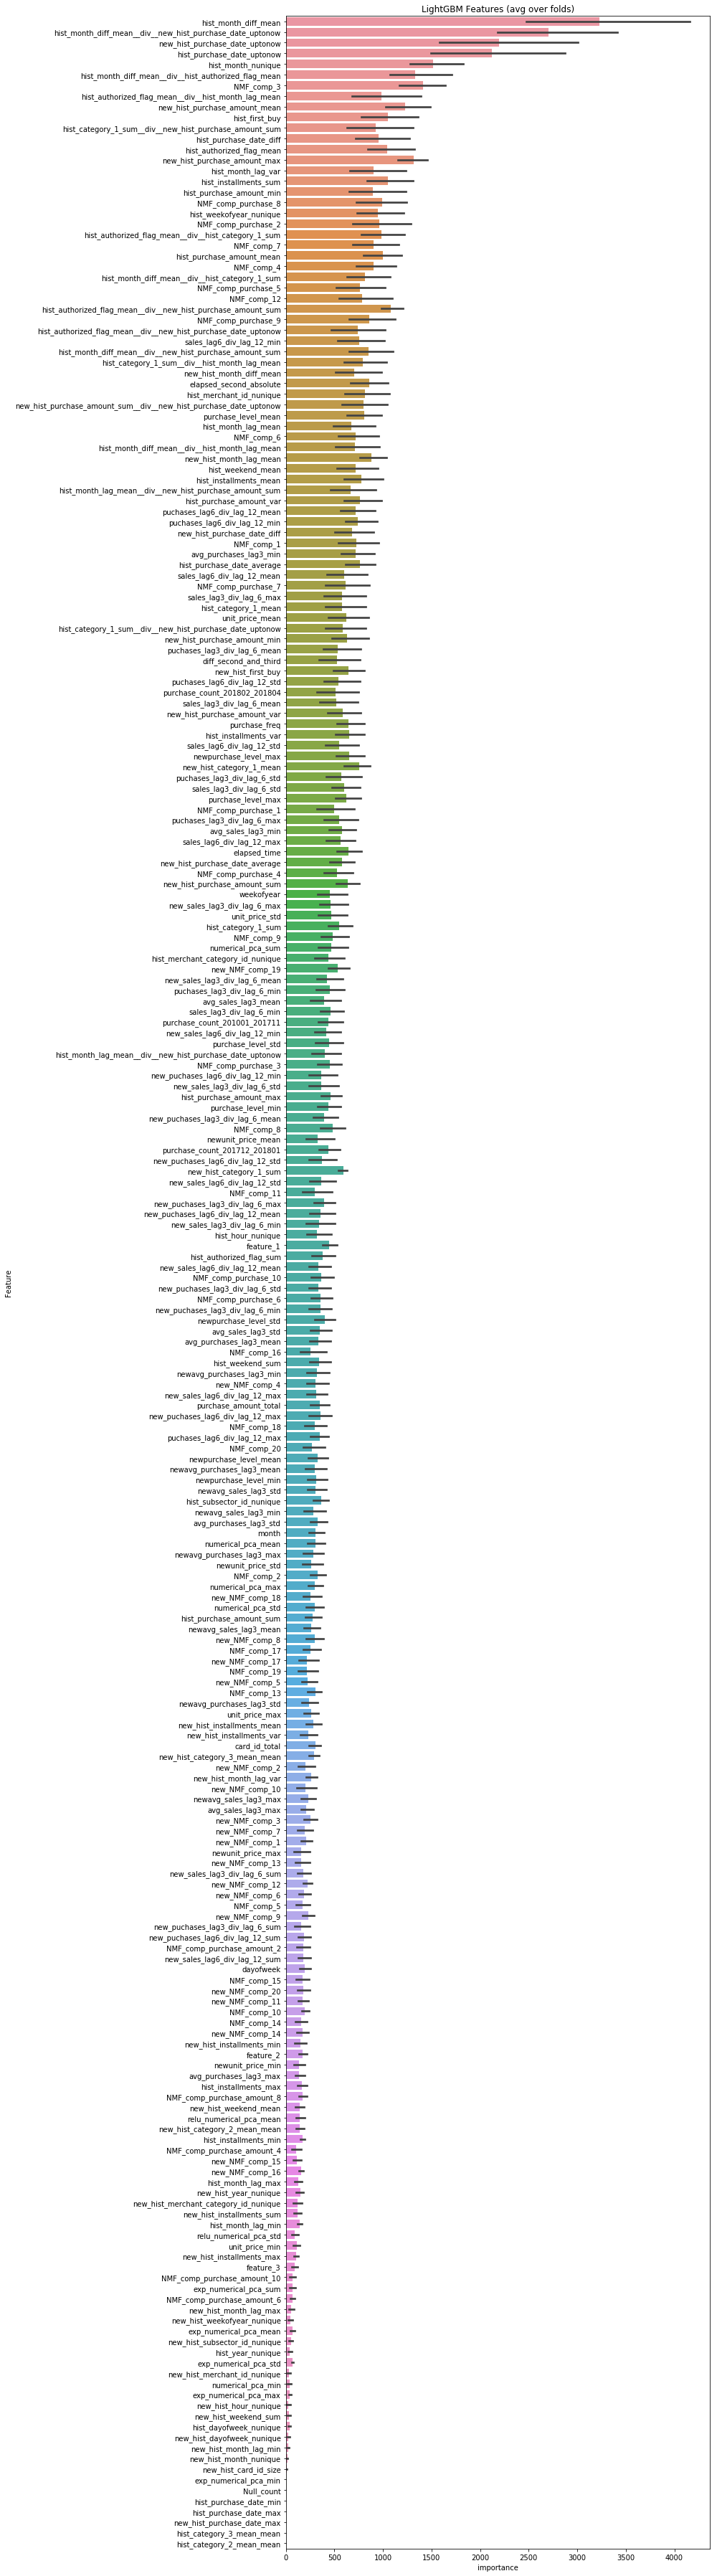

In [19]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [20]:
df_oof = pd.DataFrame({"card_id":df_train.card_id, "target":oof})
df_oof.to_csv("../input/target_train_20190120.csv", index=False)

In [21]:
df_predict = pd.DataFrameFrame({"card_id":df_test.card_id, "target":predictions})
df_predict.to_csv("../input/target_test_20190120.csv", index=False)